# Time Series Forecasting with Parametric Curve Fitting for Number of cases in Iceland

In [64]:
import warnings
warnings.filterwarnings("ignore")
from ts_utilss import *

In [65]:
dtf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", sep=",")
dtf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,949,964,969,981,989,998,1004,1029,1050,1076
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,761,762,762,762,762,762,763,763,763,763
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,52,52,58,60,61,69,70,70,71,74


In [66]:
## groupby country
dtf = dtf.drop(['Province/State','Lat','Long'], axis=1).groupby("Country/Region").sum().T

## convert index to datetime
dtf.index = pd.to_datetime(dtf.index, infer_datetime_format=True)

## create total cases column
dtf = pd.DataFrame(index=dtf.index, data=dtf["Iceland"].values, columns=["total"])

## create daily changes column
dtf["new"] = dtf["total"] - dtf["total"].shift(1)
dtf["new"] = dtf["new"].fillna(method='bfill')

In [67]:
dtf.tail()

,total,new
2020-05-24,1804,0.0
2020-05-25,1804,0.0
2020-05-26,1804,0.0
2020-05-27,1805,1.0
2020-05-28,1805,0.0


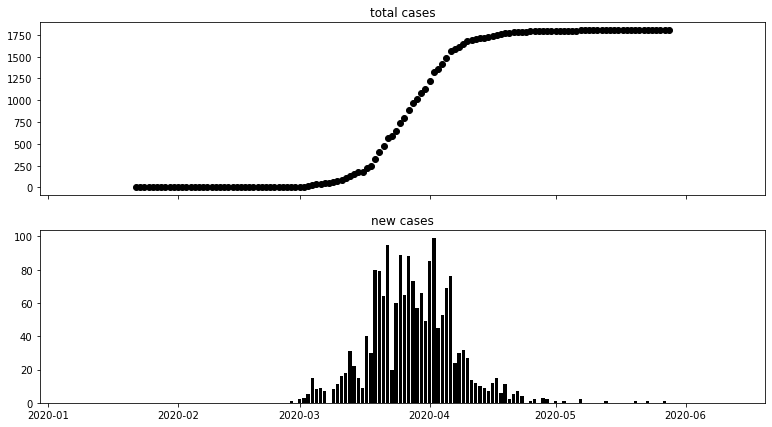

In [68]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(13,7))
ax[0].scatter(dtf.index, dtf["total"].values, color="black")
ax[0].set(title="total cases")
ax[1].bar(dtf.index, dtf["new"].values, color="black")
ax[1].set(title="new cases")
plt.show()

In [69]:
'''
Linear function: f(x) = a + b*x
'''
def f(x):
    return 13*x

y_linear = f(x=np.arange(len(dtf)))
'''
Exponential function: f(x) = a + b^x
'''
def f(x):
    return 1.05535**x

y_exponential = f(x=np.arange(len(dtf)))
'''
Logistic function: f(x) = a / (1 + e^(-b*(x-c)))
'''
def f(x): 
    return 1780 / (1 + np.exp(-0.2*(x-88)))

y_logistic = f(x=np.arange(len(dtf)))

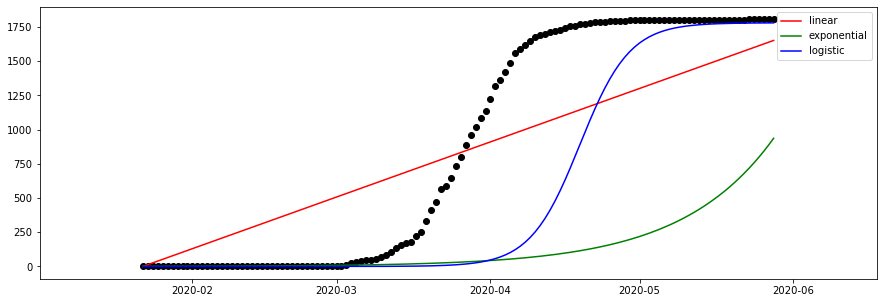

In [70]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(dtf["total"].index, dtf["total"].values, color="black")
ax.plot(dtf["total"].index, y_linear, label="linear", color="red")
ax.plot(dtf["total"].index, y_exponential, label="exponential", color="green")
ax.plot(dtf["total"].index, y_logistic, label="logistic", color="blue")
ax.legend()
plt.show()

In [101]:
'''
Gaussian function: f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(x):
    return 110 * np.exp(-0.2 * ((x-65)/6)**2)
    #return 100 * np.exp(-0.018 * ((x-90)/2)**2)

y_gaussian = f(x=np.arange(len(dtf)))

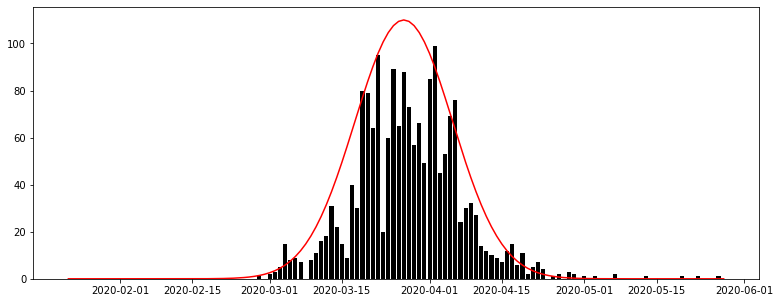

In [102]:
fig, ax = plt.subplots(figsize=(13,5))
ax.bar(dtf["new"].index, dtf["new"].values, color="black")
ax.plot(dtf["new"].index, y_gaussian, color="red")
plt.show()

## Modeling and Testing

In [73]:
'''
Function to fit. In this case logistic function:
    f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def f(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

In [74]:
## Fit
model = fit_curve(X=np.arange(len(dtf["total"])), y=dtf["total"].values, f=f, p0=[np.max(dtf["total"]), 1, 1])
model

array([1.80236990e+03, 1.77423008e-01, 6.53268963e+01])

--- generating index date --> start: 2020-05-29 00:00:00 | end: 2020-06-26 00:00:00 | len: 29 ---


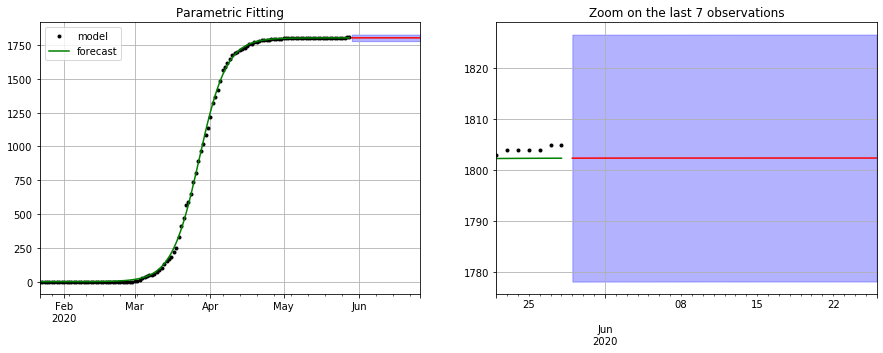

In [75]:

## Forecast
preds = forecast_curve(dtf["total"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

In [76]:
'''
Function to fit. In this case gaussian function:
    f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def f(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y

In [77]:
model = fit_curve(X=np.arange(len(dtf["new"])), y=dtf["new"].values, f=f, p0=[1, np.mean(dtf["new"]), np.std(dtf["new"])])
model

array([76.35995274, 65.7658059 , -9.27602503])

--- generating index date --> start: 2020-05-29 00:00:00 | end: 2020-06-26 00:00:00 | len: 29 ---


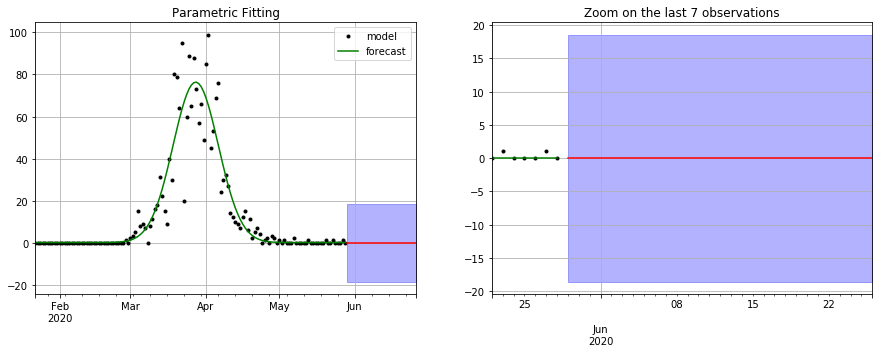

In [78]:
## Forecast
preds = forecast_curve(dtf["new"], f, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

### Webgraphy

* Parametric Curve Fitting: https://medium.com/analytics-vidhya/how-to-predict-when-the-covid-19-pandemic-will-stop-in-your-country-with-python-d6fbb2425a9f